In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import seaborn as sns
import math

from scipy.spatial.distance import pdist, cdist,squareform
from scipy import linalg

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn import datasets
from sklearn.datasets import make_circles, make_moons, make_blobs, make_classification
from sklearn.preprocessing import StandardScaler

FUNCTION FOR SPECTRAL CLUSTERING WITH CUSTOM IMPLEMENTATION

In [2]:
def spectral_clustering(dataframe, similarity_graph, laplacian, number_of_clusters, eps=None, k=None):

    # Pairwise distances
    dimension = dataframe.shape[0]
    dist_mat = squareform(pdist(dataframe))

    sample_size = len(dist_mat)
    
    # Set n based on proportional selection, but limit by log scaling for large datasets
    n = min(sample_size // 10, int(math.log(sample_size)))

    # Fallback values for epsilon and k
    epsilon = eps if eps else np.percentile(dist_mat, 90)
    k = k if k else int(np.sqrt(sample_size))
    
    if similarity_graph == "full":

        #calculate local sigma
        sigmas = np.zeros(dimension)
        for i in tqdm(range(len(dist_mat))):
            sigmas[i] = np.partition(dist_mat[i], n)[n]

        # Adjaceny matrix with optimal sigma
        adjacency_matrix = np.zeros([dimension, dimension])
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):  
                d = np.exp(-1*dist_mat[i, j]**2/(sigmas[i]*sigmas[j]))
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d

    
    elif similarity_graph == "eps":

        # Adjaceny matrix with epsilon threshold
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):
                if dist_mat[i, j] < epsilon:
                    d = 1
                else:
                    d = 0
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d


    elif similarity_graph == "knn":

        # Adjaceny matrix with k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            # Update the adjacency matrix
            adjacency_matrix[i, k_nearest_indices] = 1


    else:

        # Adjaceny matrix with mutual k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            for neighbor in k_nearest_indices:
                # Check if node i is also among the k-nearest neighbors of the current neighbor
                neighbor_sorted_indices = np.argsort(dist_mat[neighbor])
                if i in neighbor_sorted_indices[1:k+1]:
                    # Connect nodes if they are mutual k-nearest neighbors
                    adjacency_matrix[i, neighbor] = 1
                    adjacency_matrix[neighbor, i] = 1

    # Calculate the degree matrix
    dimension = len(adjacency_matrix)
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

    # Identify isolated nodes (degree = 0)
    isolated_nodes = np.where(np.diag(degree_matrix) == 0)[0]
    non_isolated_mask = np.isin(np.arange(dimension), isolated_nodes, invert=True)

    # Handle non-isolated nodes only for clustering
    adjacency_matrix_non_isolated = adjacency_matrix[non_isolated_mask][:, non_isolated_mask]
    degree_matrix_non_isolated = degree_matrix[non_isolated_mask][:, non_isolated_mask]

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = linalg.fractional_matrix_power(degree_matrix_non_isolated, -0.5)
        laplacian_matrix_normalized = d_half @ adjacency_matrix_non_isolated @ d_half
    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = linalg.fractional_matrix_power(degree_matrix_non_isolated, -1)
        laplacian_matrix_normalized = d_inverse @ adjacency_matrix_non_isolated


    if laplacian == "ad":
        
        # Adaptive Laplacian matrix
        degree_vector = np.diag(degree_matrix_non_isolated)
        D_local = np.zeros_like(degree_vector)
        
        for i in range(len(degree_vector)):
            neighbors = np.where(adjacency_matrix_non_isolated[i] > 0)[0]
            if len(neighbors) > 0:
                D_local[i] = np.sum(adjacency_matrix_non_isolated[neighbors]) / degree_vector[i]
            else:
                D_local[i] = 0
        
        D_local_matrix = np.diag(D_local)
        D_local_inv = linalg.fractional_matrix_power(D_local_matrix, -0.5)
        laplacian_matrix_normalized = D_local_inv @ adjacency_matrix_non_isolated @ D_local_inv
    
    
    if check_symmetric(laplacian_matrix_normalized) :
        # Calculating eigenvalues and eigenvectors for symmetric matrix
        e, v = np.linalg.eigh(laplacian_matrix_normalized)
    else:
        # Calculating eigenvalues and eigenvectors for non-symmetric matrix
        e, v = np.linalg.eig(laplacian_matrix_normalized)
        idx = np.argsort(np.real(e))
        e = np.real(e[idx])
        v = np.real(v[:, idx]) 
    
    # Calculate eigengap
    eigengap = np.diff(e)
    optimal_number_of_clusters = np.argmax(eigengap[:10]) + 1   
    
    # Use k=2 for circles and moons, eigengap for others
    if number_of_clusters == "fixed2":
        current_k = 2  # For circles and moons
    elif number_of_clusters == "fixed3":
        current_k = 3  # For circles and moons:
    else:
        current_k = optimal_number_of_clusters

    results = []
    
    # Perform clustering on the non-isolated nodes
    X = v[:, -current_k:]
    clustering = KMeans(n_clusters=current_k)
    clustering.fit(X)
    non_isolated_labels = clustering.labels_

    # Full label assignment
    full_labels = np.full(dimension, -1)
    full_labels[non_isolated_mask] = non_isolated_labels

    # Assign isolated nodes based on nearest non-isolated neighbors
    if len(isolated_nodes) > 0:
        isolated_points = dataframe[isolated_nodes]

        # Calculate distances to non-isolated points in original space
        non_isolated_points = dataframe[non_isolated_mask]
        distances_to_non_isolated = cdist(isolated_points, non_isolated_points)

        # Assign labels based on the closest non-isolated point
        nearest_non_isolated_indices = np.argmin(distances_to_non_isolated, axis=1)
        isolated_labels = full_labels[non_isolated_mask][nearest_non_isolated_indices]
        full_labels[isolated_nodes] = isolated_labels

    return [(current_k, full_labels)]

In [3]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [4]:
# Set random seed for reproducibility
np.random.seed(0)

# Hyperparameters from scikit-learn's example
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

# Custom dataset generation
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = (np.random.rand(n_samples, 2), None)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# List of datasets with hyperparameters
datasets_with_params = [
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2, 'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2, 'min_samples': 5, 'xi': 0.035, 'n_clusters': 3}),
    (aniso, {'eps': .15, 'n_neighbors': 2, 'min_samples': 20, 'xi': 0.1, 'n_clusters': 3}),
    (blobs, {'n_clusters': 3}),
    (no_structure, {})
]

# Similarity graph types and Laplacian types
similarity_graphs = ["full", "eps", "knn", "mknn"]
laplacians = ["sym", "rw", "ad"]

In [5]:
def plot_spectral_clustering_with_additional_datasets():
    # Iterate over datasets and hyperparameters
    for dataset, params in datasets_with_params:
        X, y_true = dataset
        
        X = StandardScaler().fit_transform(X)
        
        fig, axs = plt.subplots(len(similarity_graphs), len(laplacians), figsize=(20, 16))
        fig.suptitle(f"Spectral Clustering for {params.get('dataset_name', 'Dataset')}", fontsize=20)

        for i, similarity_graph in enumerate(similarity_graphs):
            for j, laplacian in enumerate(laplacians):
                if params.get('n_clusters', 'eigengap') == 2:
                    num_clusters = "fixed2"
                elif params.get('n_clusters', 'eigengap') == 3:
                    num_clusters = "fixed3"
                else:
                    num_clusters = "eigengap"

                result = spectral_clustering(X, similarity_graph, laplacian, num_clusters, eps=params.get('eps'), k=params.get('n_neighbors'))
                current_k, labels = result[0]
                
                ax = axs[i, j]
                scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
                ax.set_title(f"{similarity_graph} - {laplacian} (k={current_k})", fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

100%|██████████████████████████████████████| 1500/1500 [00:03<00:00, 417.16it/s]


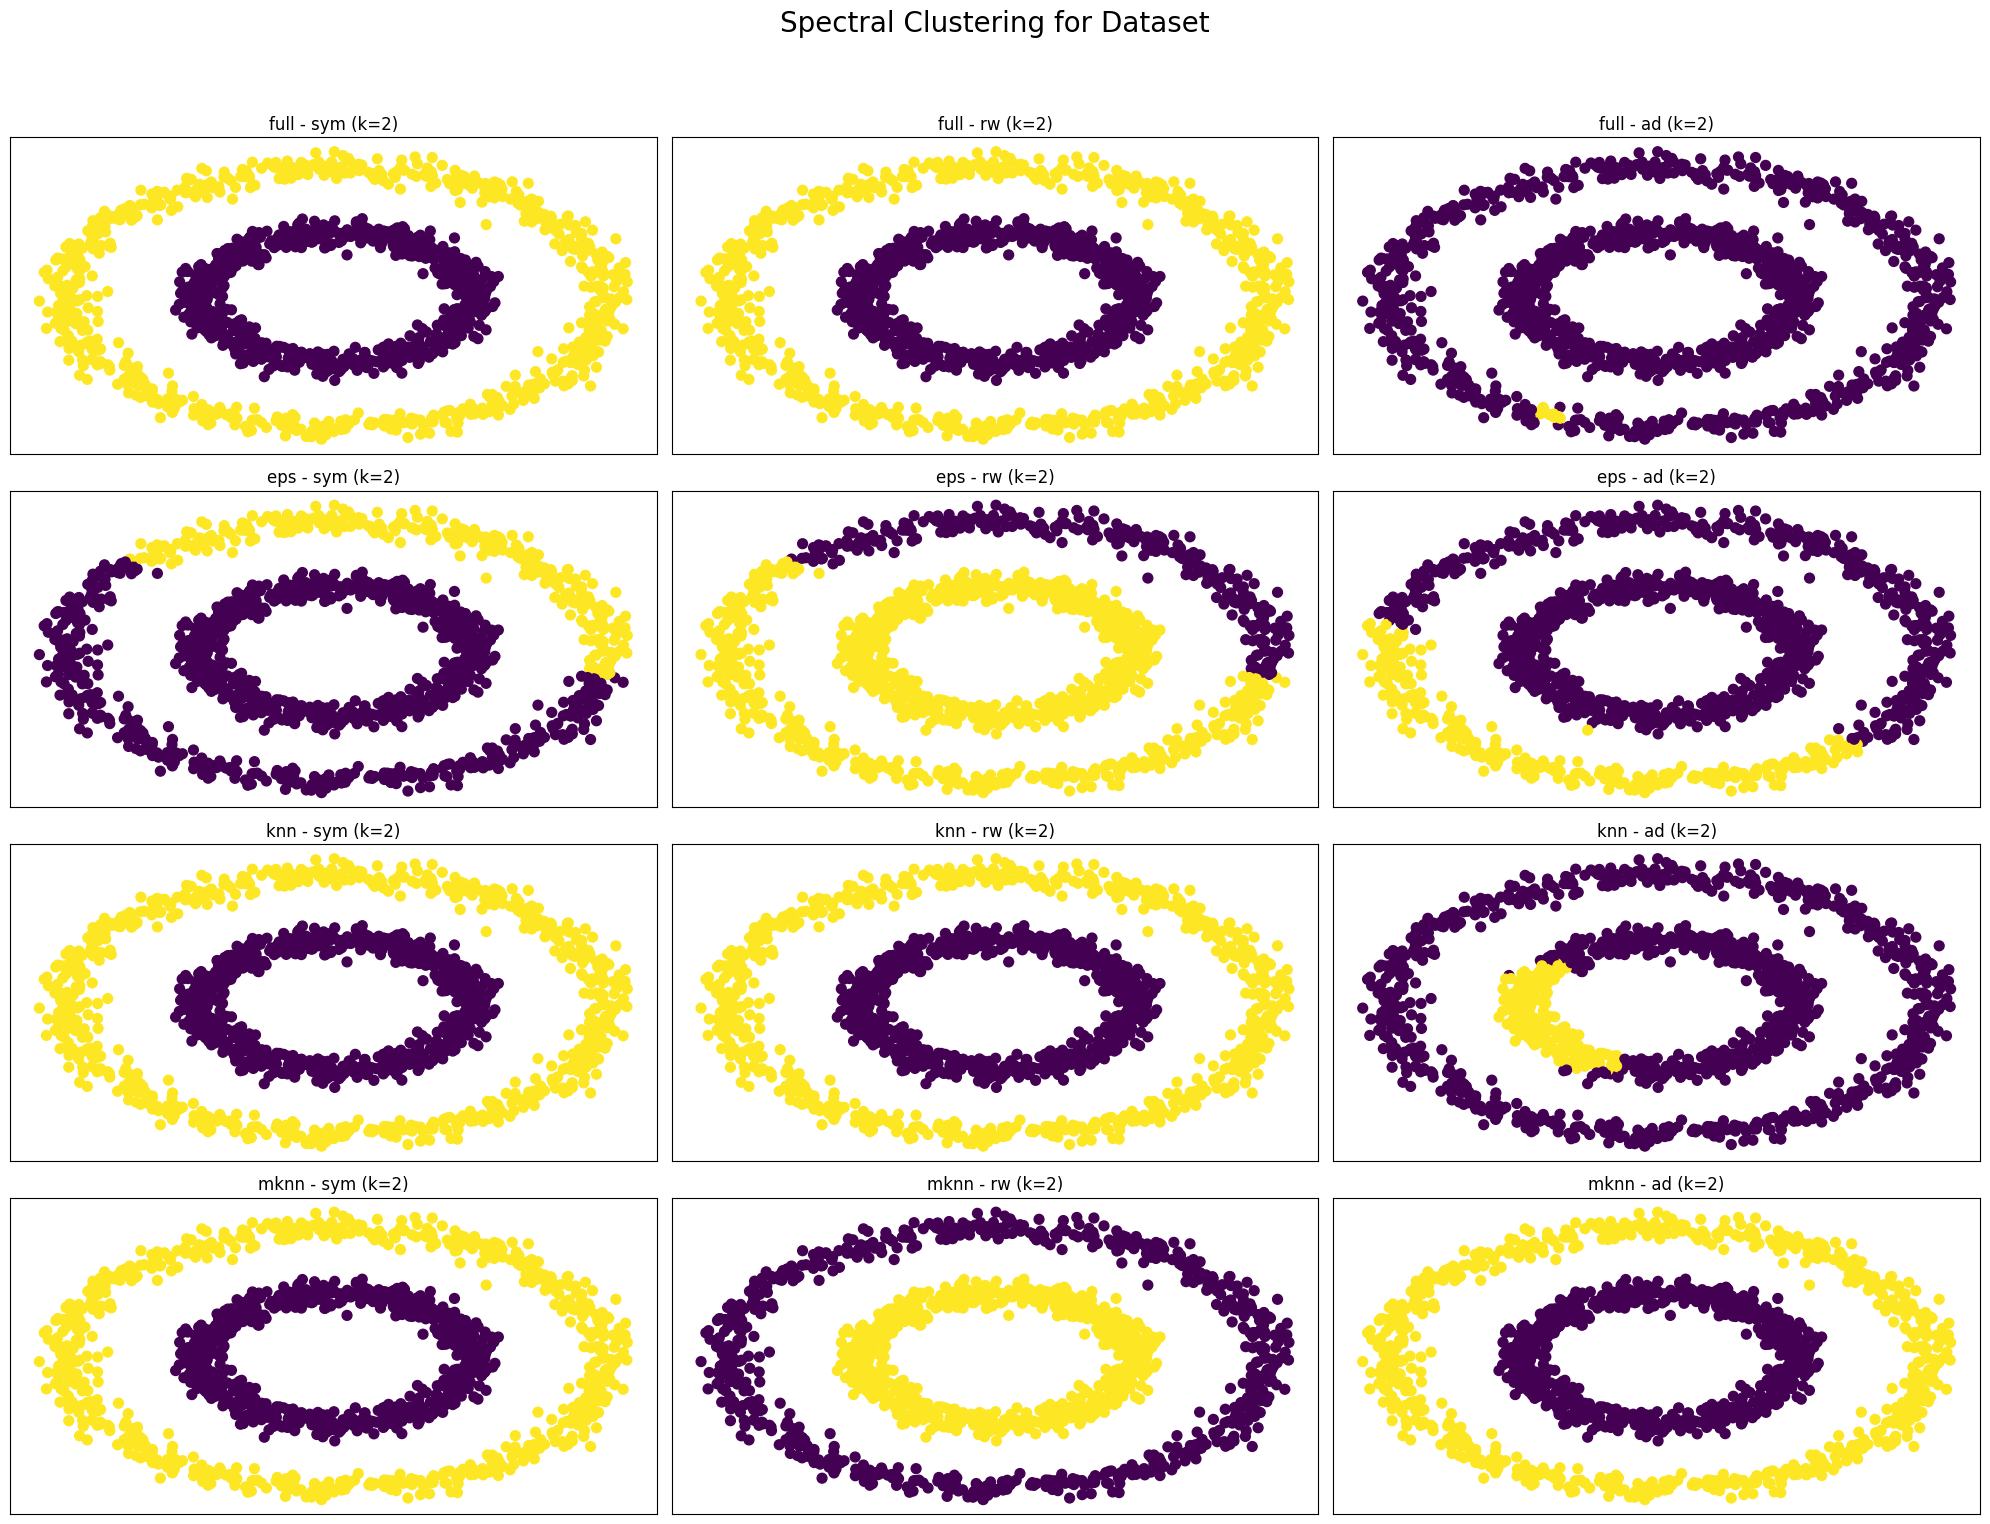

100%|██████████████████████████████████████| 1500/1500 [00:03<00:00, 418.99it/s]


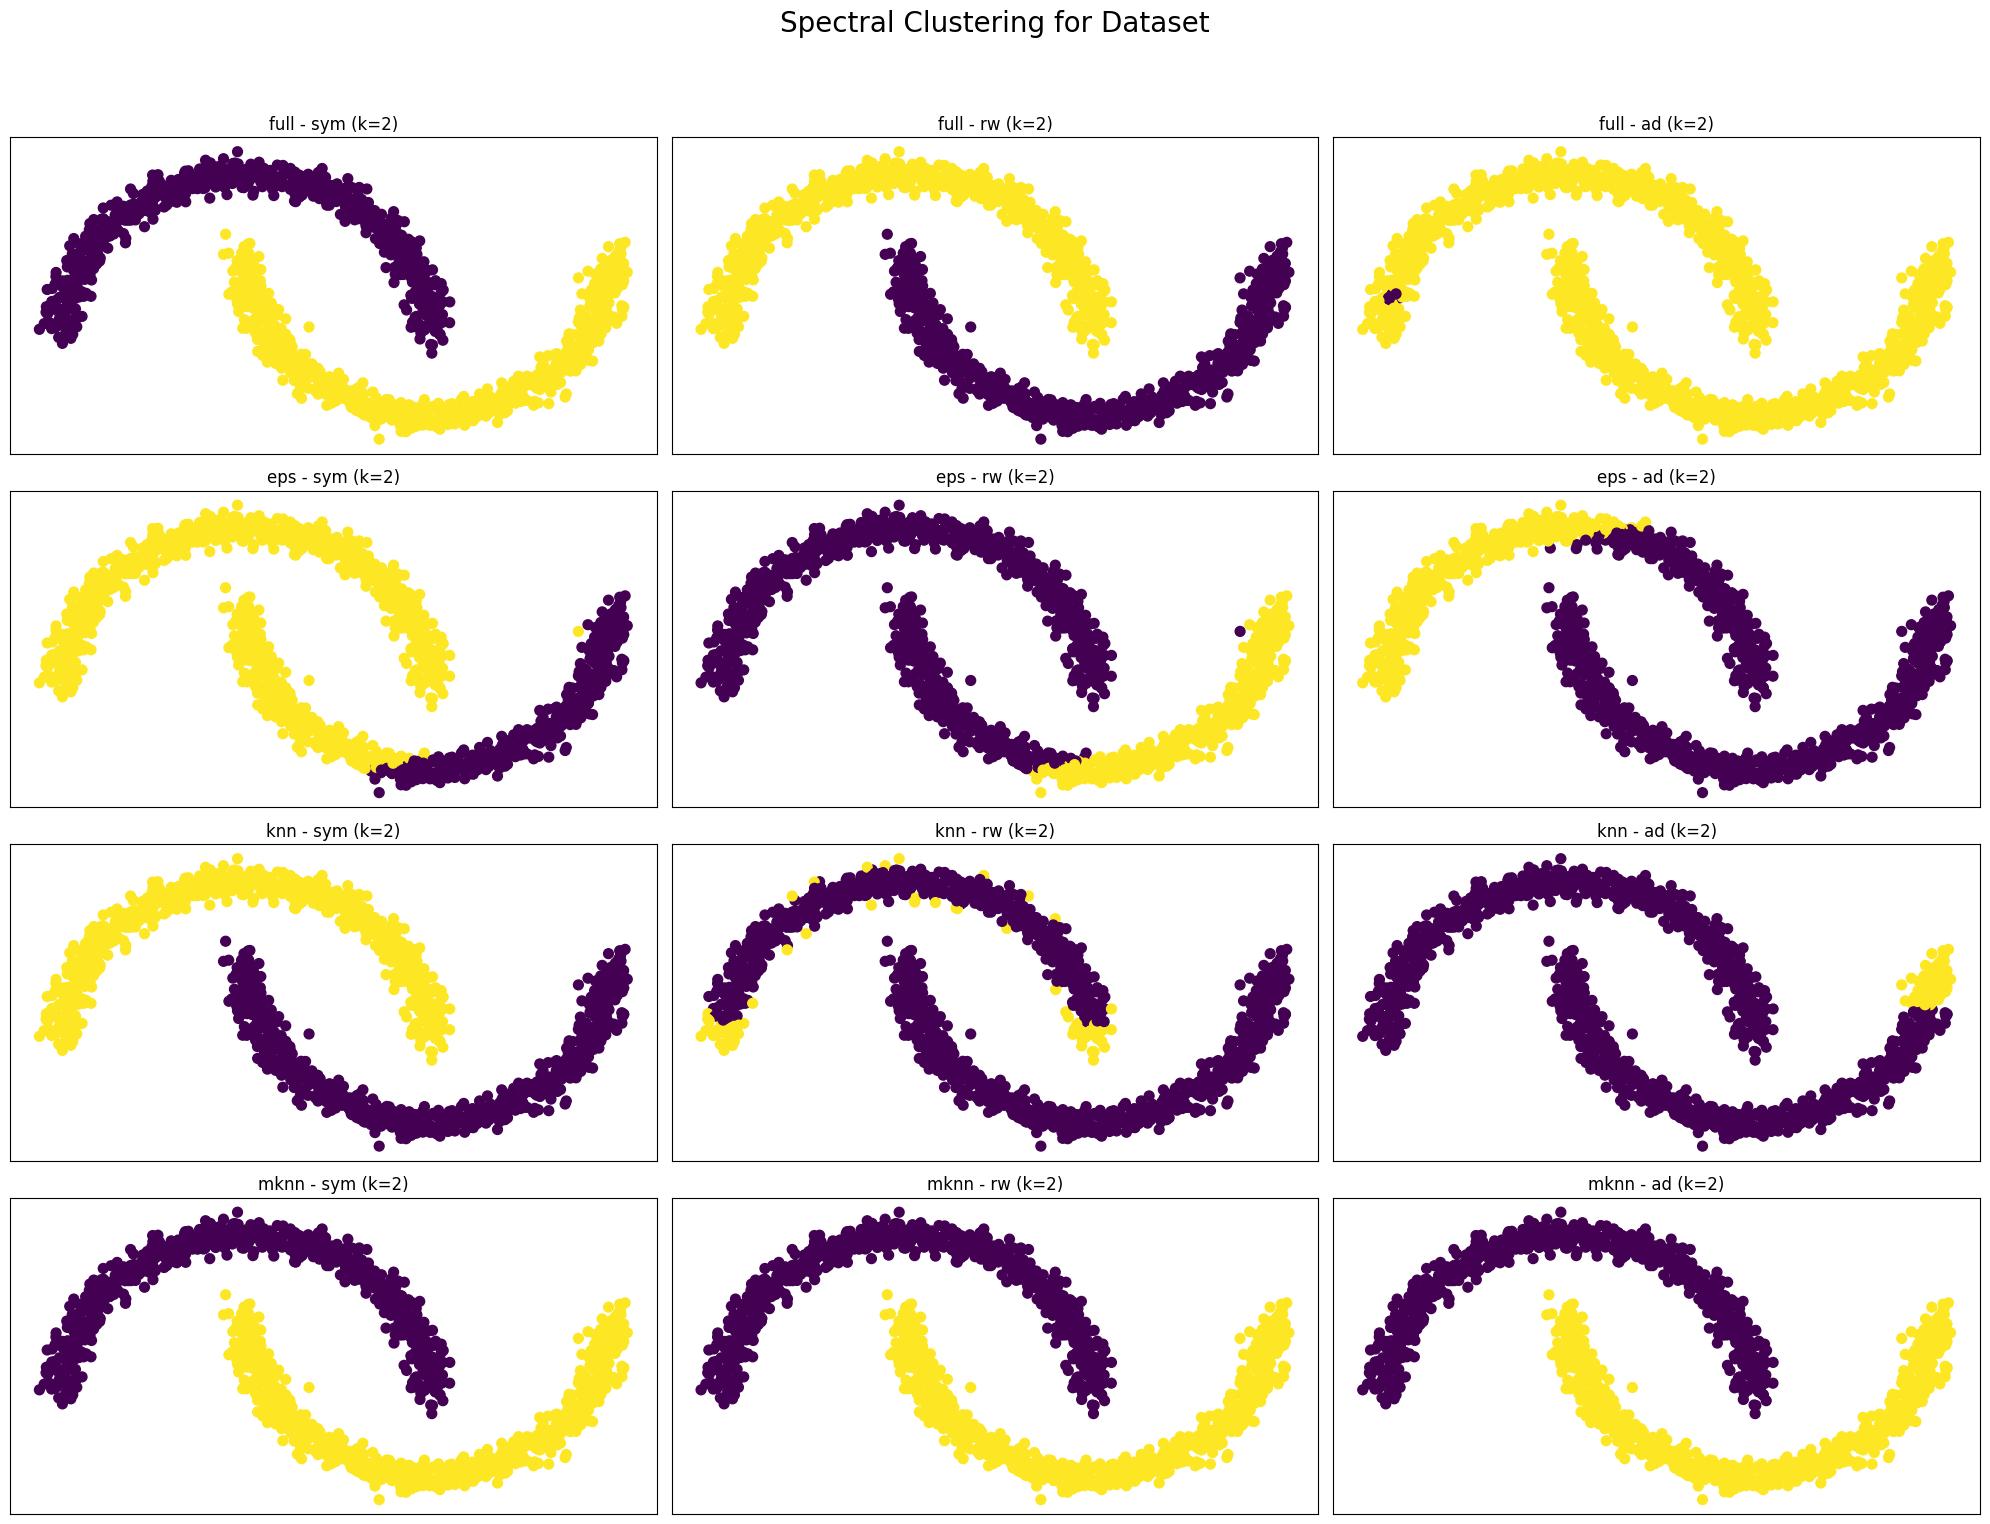

100%|█████████████████████████████████████| 1500/1500 [00:00<00:00, 5251.11it/s]


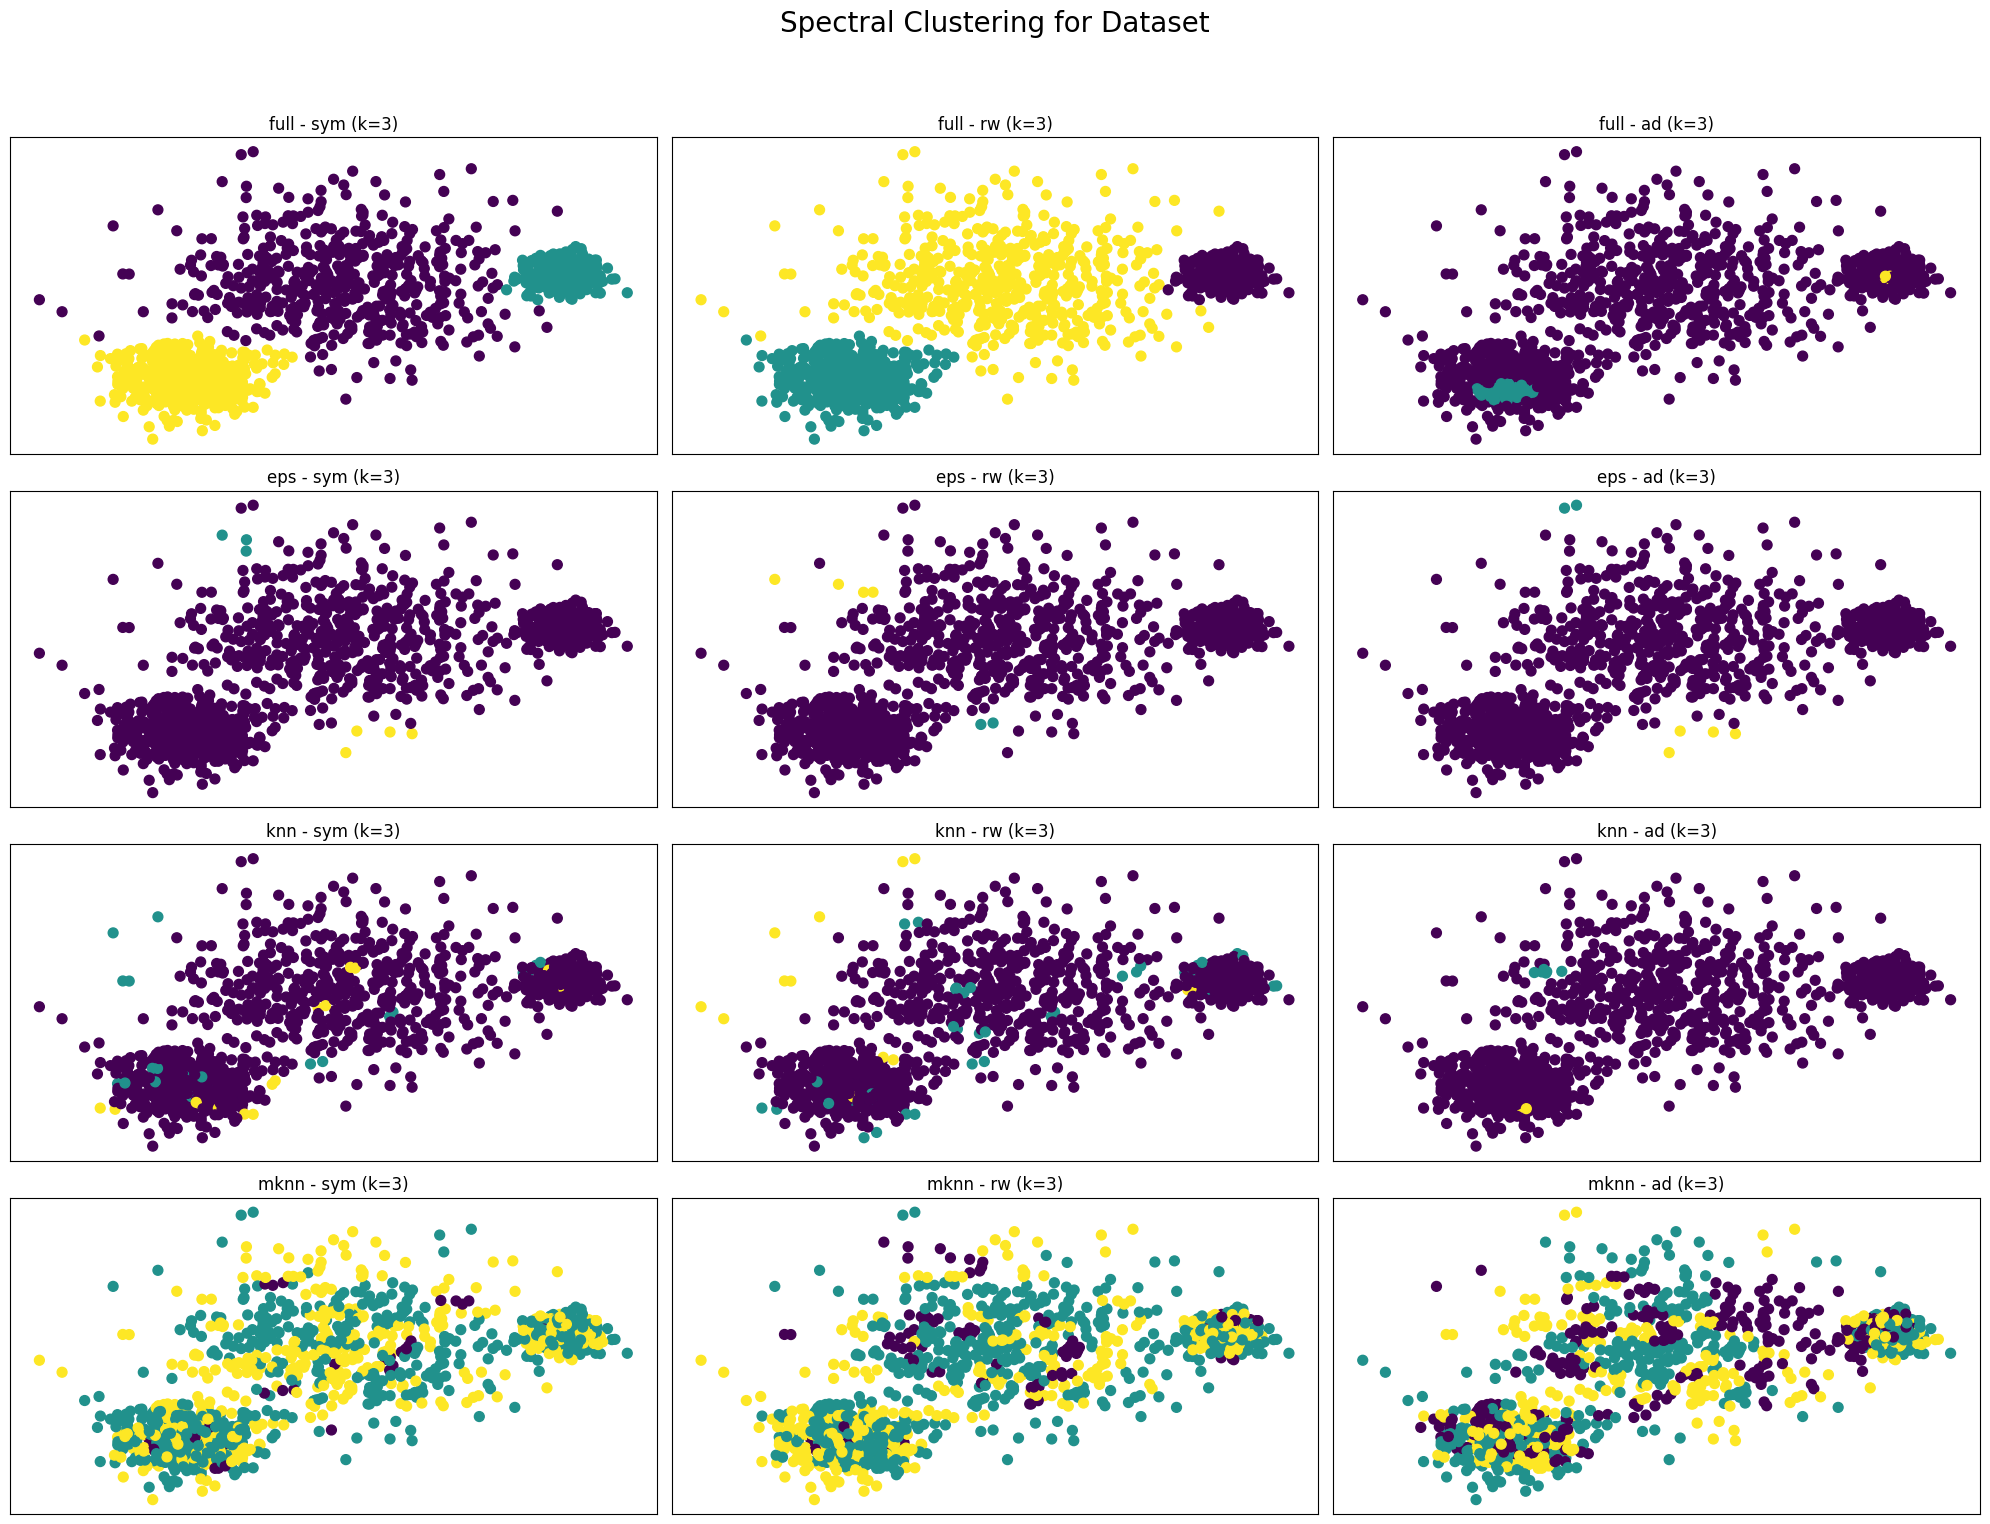

100%|█████████████████████████████████████| 1500/1500 [00:00<00:00, 5268.50it/s]


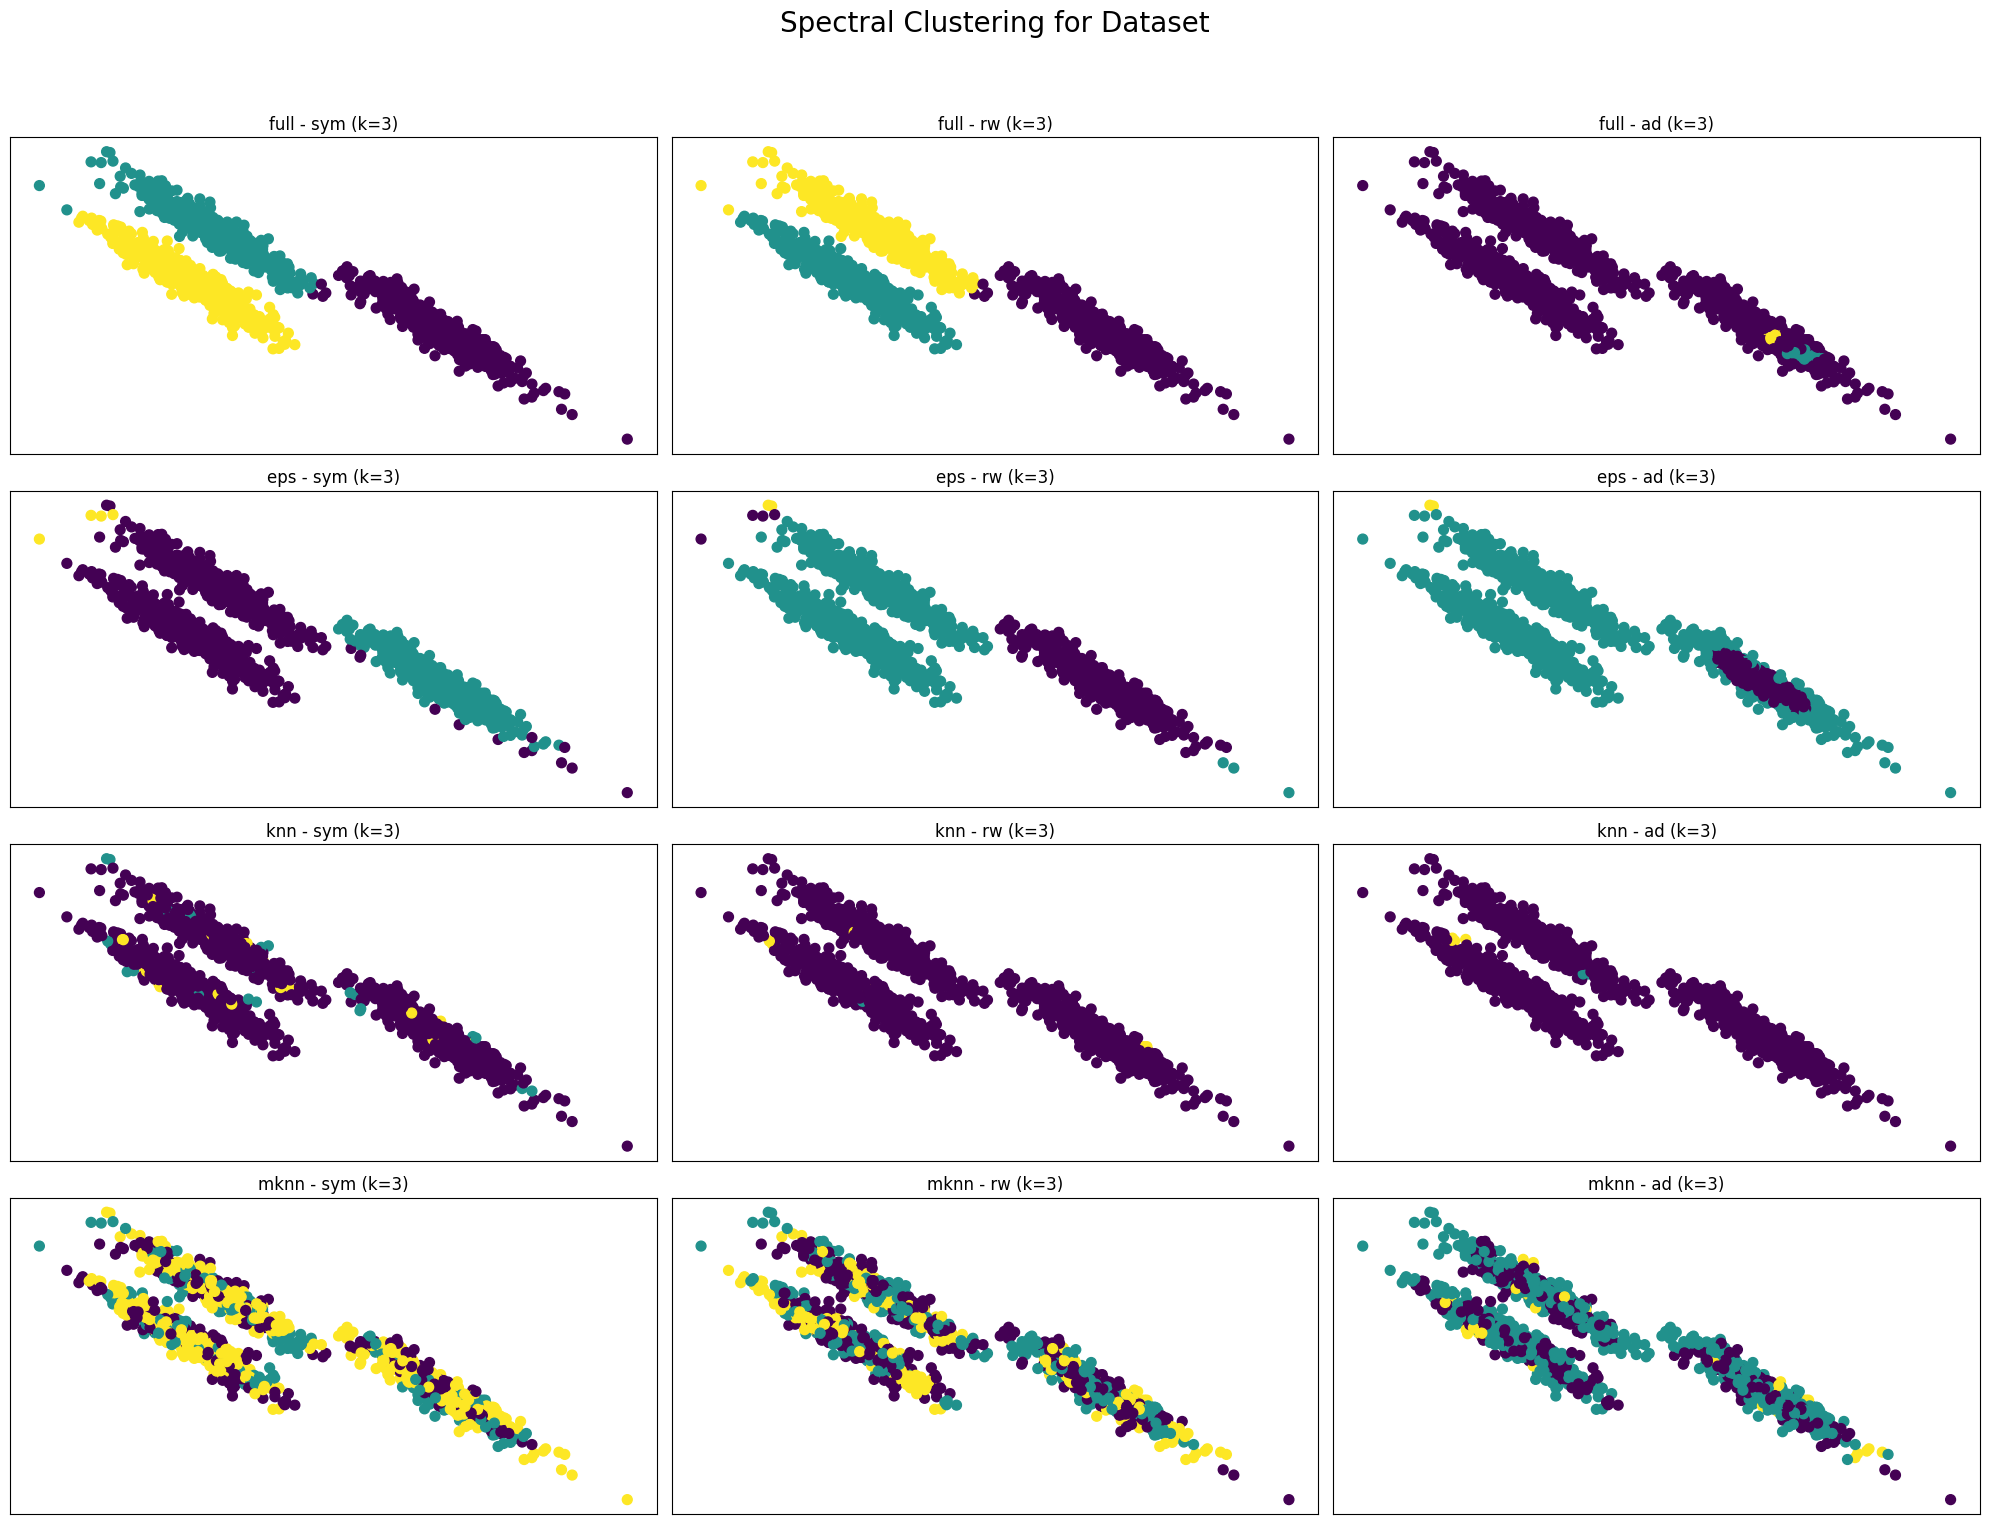

100%|██████████████████████████████████████| 1500/1500 [00:03<00:00, 438.28it/s]


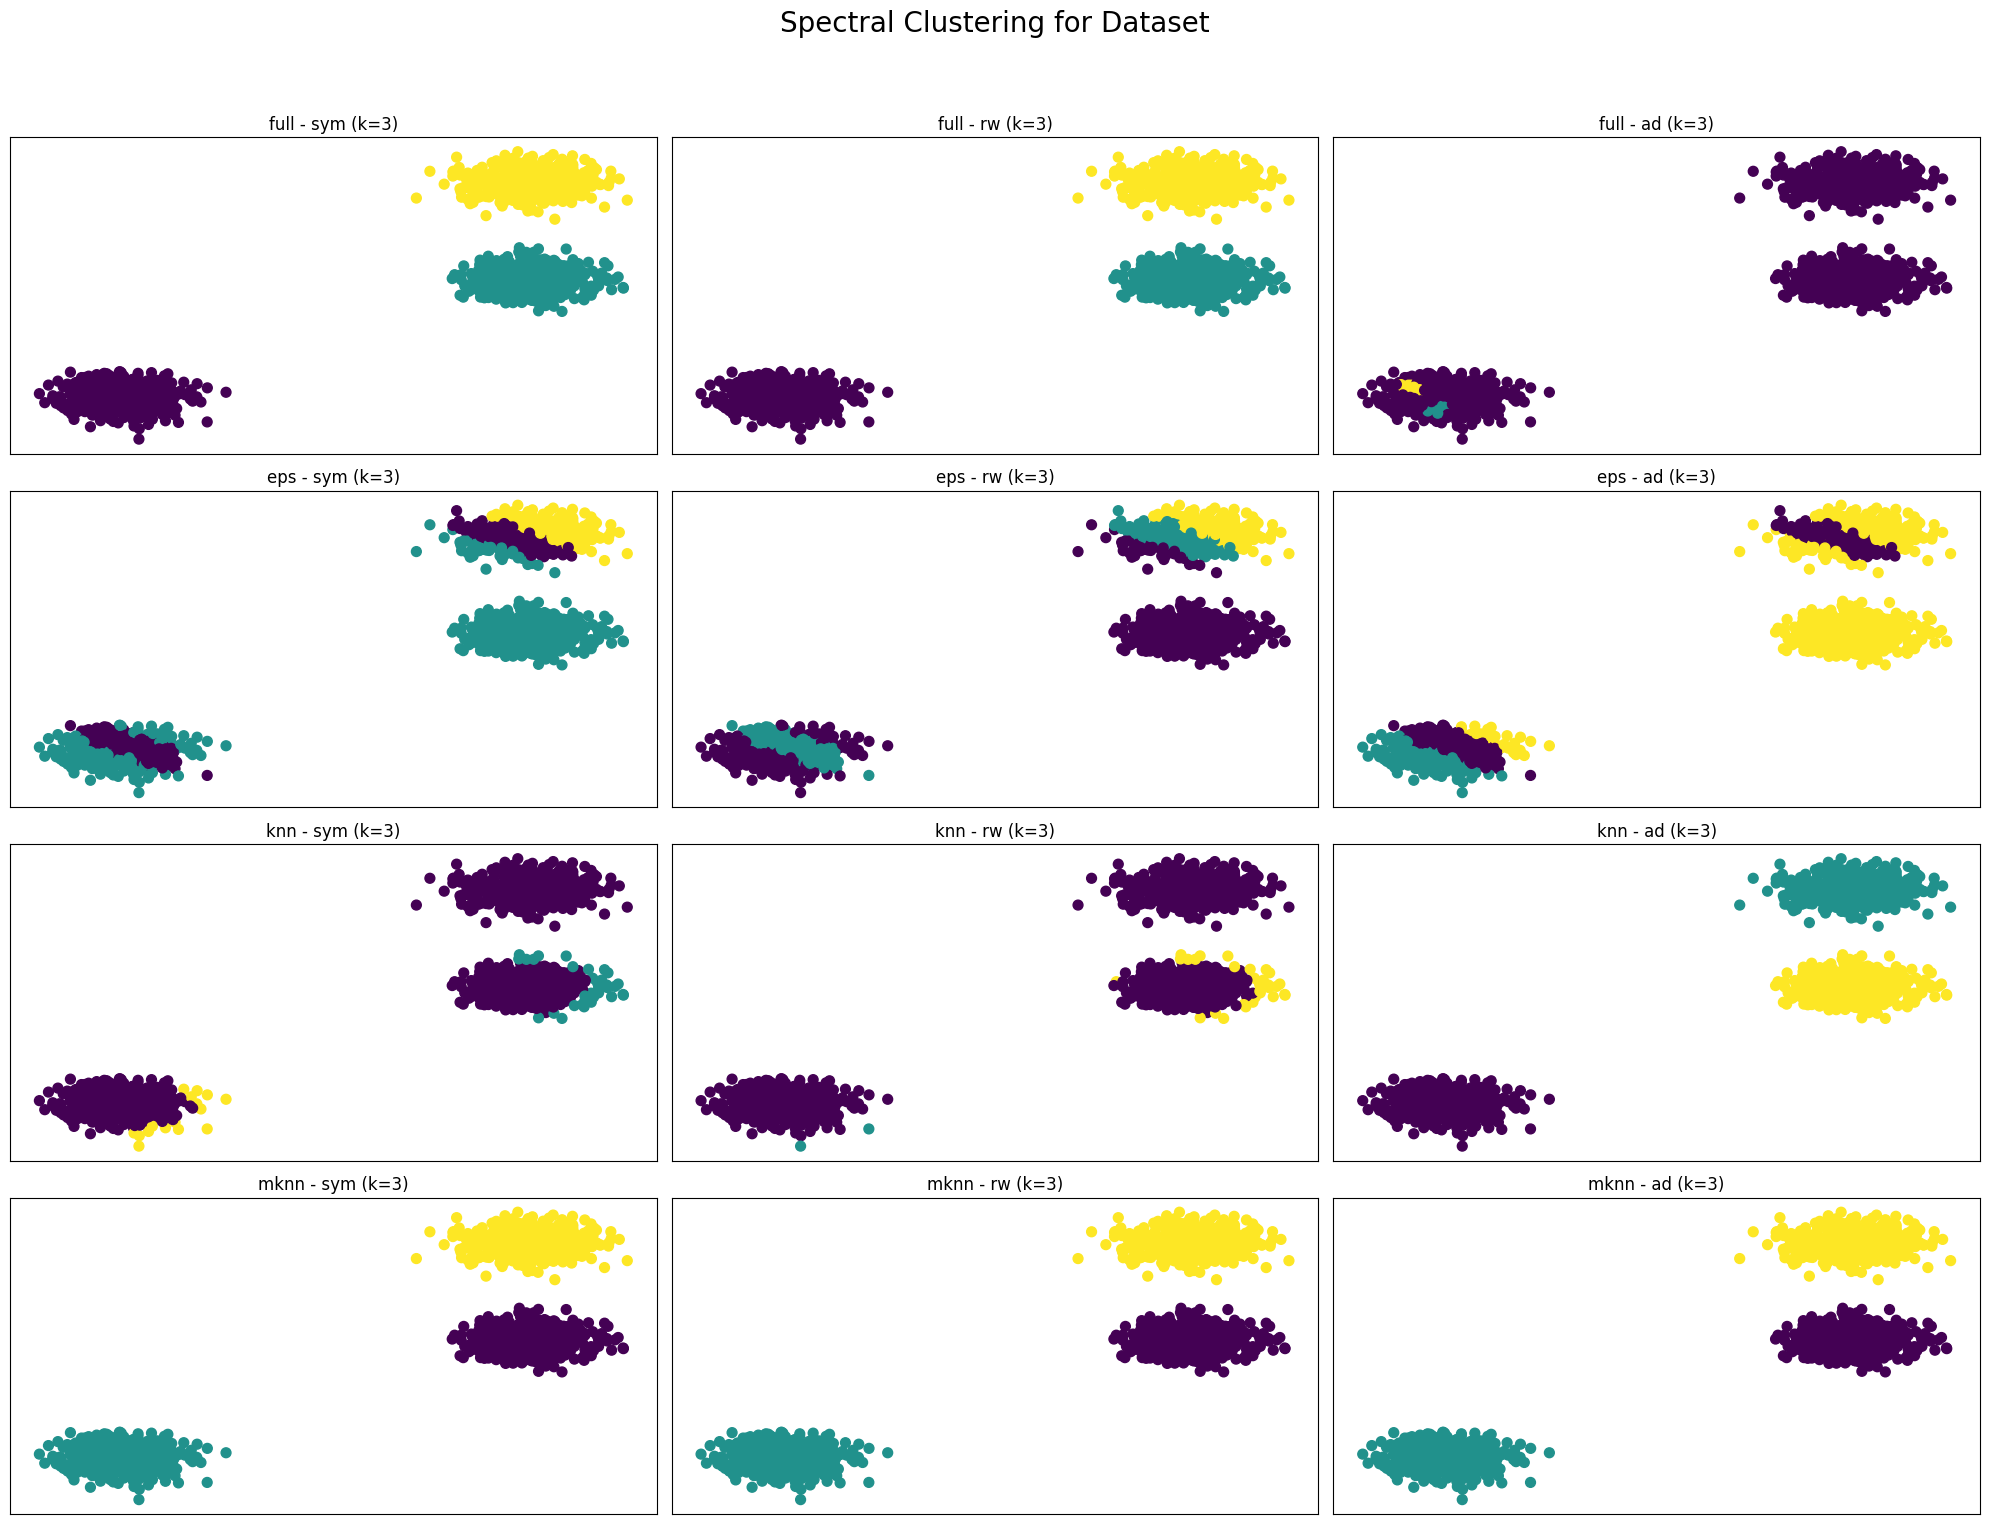

100%|██████████████████████████████████████| 1500/1500 [00:03<00:00, 422.66it/s]


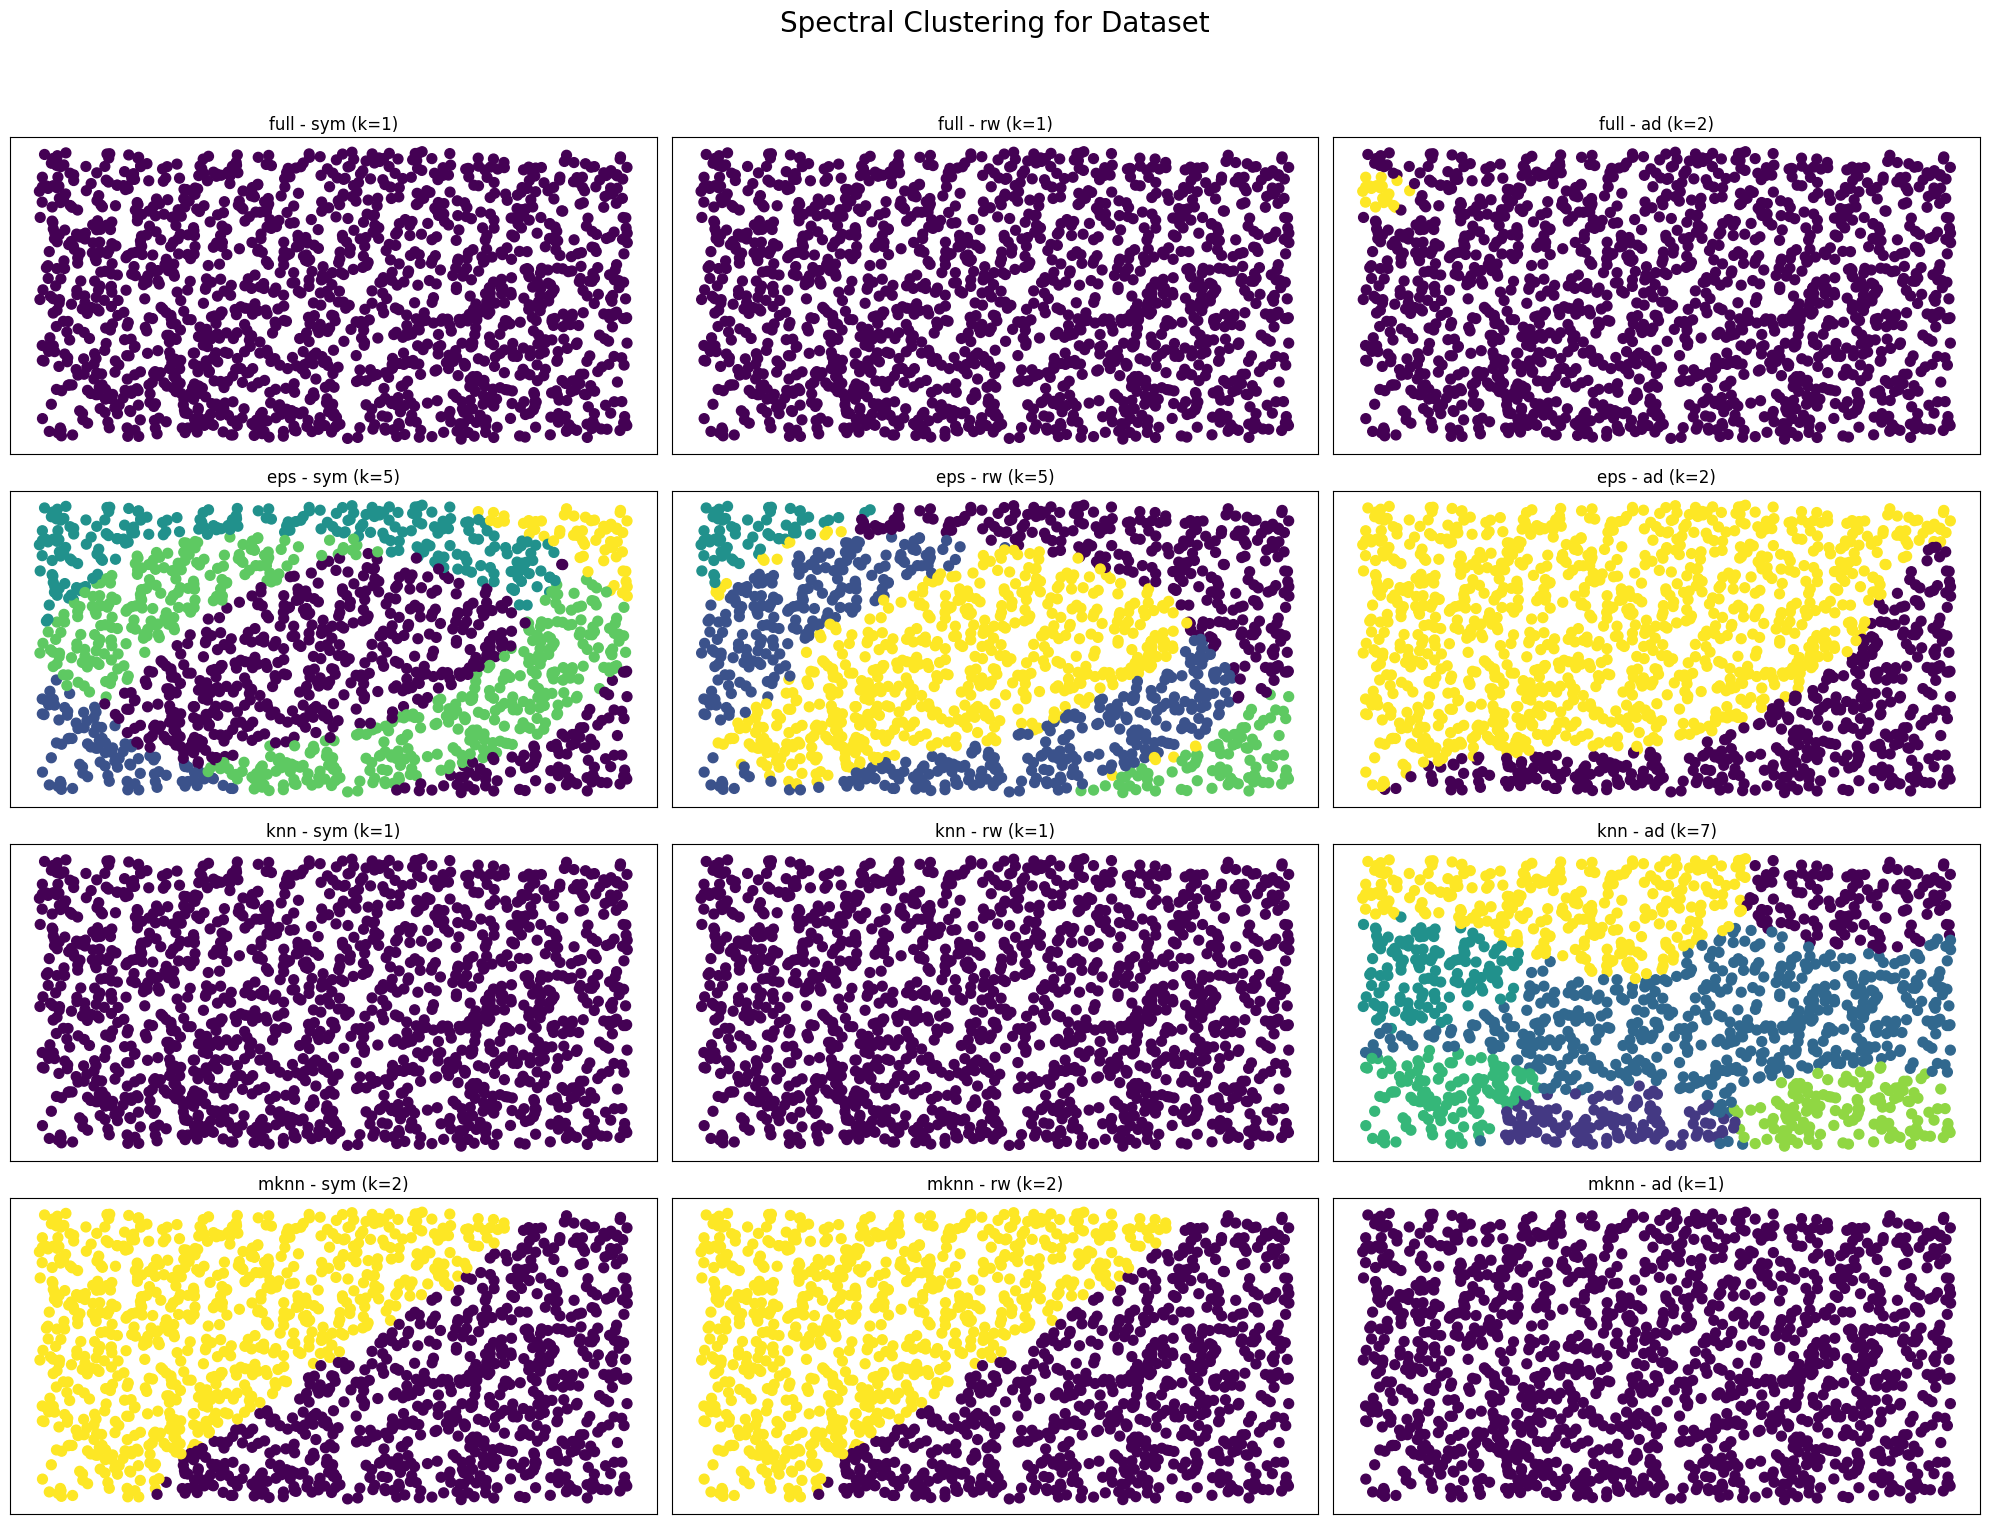

In [6]:
plot_spectral_clustering_with_additional_datasets()